In [1]:
import os
import sys

import torch
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from optimization import functions
from optimization.updater import Updater

from utils import constants, common
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
grand_parent_path = os.path.dirname(parent_path)

In [4]:
results_path = os.path.join(grand_parent_path, "results")

In [5]:
dataset_path = os.path.join(grand_parent_path, "dataset")
demo_path = os.path.join(dataset_path, "human_demonstrations")

In [6]:
# collected dataset folder name in ("dataset \\ human_demonstrations \\ collection_date")
collection_date = "2024_01_23" # year_month_day

In [7]:
dataset_folder = os.path.join(demo_path, collection_date)

In [8]:
json_files = os.listdir(dataset_folder + "\\jsons")

In [9]:
column_names = constants.COLUMN_NAMES

In [10]:
configs = Config()
# call the parameters method to set the parameters
configs.parameters()

Current Time:  Feb_11_2024-22_14_03


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)
configs.device = device

configs = functions.setup_config(device=device)

Training Device:  cpu
Current Time:  Feb_11_2024-22_14_03


In [12]:
policy_model_directory = os.path.join(results_path,
                               "policy_network_params")

if not os.path.exists(policy_model_directory):
    os.makedirs(policy_model_directory)

In [13]:
policy_saving_path, reward_saving_path = functions.create_directories(configs=configs,
                                                                      results_path=results_path,
                                                                      saving_policy=True,
                                                                      saving_reward=True)

In [14]:
json_paths_train, results_path = functions.get_directories(parent_directory=parent_directory,
                                                     data_folder_name=constants.DEMO_COLLECTION_DATE) # DEMO_COLLECTION_DATE, TEST_COLLECTION_DATE

In [15]:
training_data = PolicyDatasetLoader(demo_data_json_paths=json_paths_train)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  30
Full Demo Dataset Size:  1379


In [16]:
train_loader = torch.utils.data.DataLoader(training_data,
                                           batch_size=configs.batch_size,
                                           shuffle=configs.data_shuffle,
                                           num_workers=configs.num_workers)

In [17]:
trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=training_data)

In [18]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)
    
reward_network = RewardFunction(state_action_size=configs.state_action_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

In [19]:
updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)
updater_obj.initialize_optimizers()

In [20]:
mean_rewards = []
mean_loss_reward = []
mean_loss_policy = []
EPISODES_TO_PLAY = 1
REWARD_FUNCTION_UPDATE = 10
DEMO_BATCH = 100
sample_trajs = []

In [21]:
D_demo, D_samp = np.array([]), np.array([])

In [22]:
demo_traj_list = []

In [23]:
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=False,
                                        is_inference_policy=False)
    demo_traj_list.append(traj_df)
    del traj_df

In [24]:
def preprocess_traj(traj_list, step_list, is_Demo=False):
    step_list = step_list.tolist()
    
    for traj_df in traj_list:
        
        if is_Demo:
        
            states = traj_df[["state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values
            actions = traj_df[["action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values
            next_states = traj_df[["next_state_label_norm_1", "next_state_label_norm_2", "next_state_label_norm_3"]].values
            probs = np.ones((actions.shape[0], actions.shape[1]))
        
        else:
            states = np.array([state_tensor[0].numpy() for state_tensor in traj_df[0]])
            actions = np.array([action_tensor.clone().detach()[0].numpy() for action_tensor in traj_df[1]])
            probs = np.array([prob_tensor.clone().detach()[0].numpy() for prob_tensor in traj_df[2]])
            rewards = np.array([reward_tensor.clone().detach()[0].numpy() for reward_tensor in traj_df[3]])
        
        x = np.concatenate((states, probs, actions), axis=1)
        step_list.extend(x)
    
    return np.array(step_list)

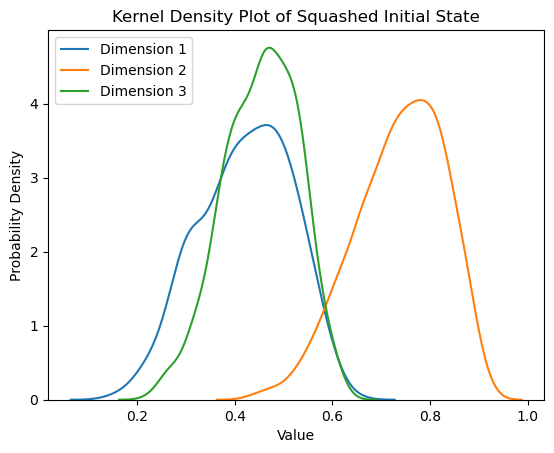

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def squash_to_range(x, min_value, max_value):
    return 1 / (1 + np.exp(-x)) * (max_value - min_value) + min_value

def squash_fun(x, min_value, max_value):
    return 0.5 * (x + 1) * (max_value - min_value) + min_value

# Define initial state means and variances
initial_state_means = [0.3, 0.8, 0.4]
initial_state_variances = [0.4, 0.5, 0.3]

# Define specific ranges for squashing
min_ranges = [0.05, 0.30, 0.10]
max_ranges = [0.70, 0.95, 0.70]

# Generate random samples for the initial state
state_0_rand = np.random.normal(loc=initial_state_means, scale=np.sqrt(initial_state_variances), size=(1000, len(initial_state_means)))

# Squash the random samples to the specified ranges
state_0_squashed = np.zeros_like(state_0_rand)
for i in range(len(initial_state_means)):
    state_0_squashed[:, i] = squash_to_range(x=state_0_rand[:, i], min_value=min_ranges[i], max_value=max_ranges[i])

# Plot the squashed values
for i in range(len(initial_state_means)):
    sns.kdeplot(state_0_squashed[:, i], label=f'Dimension {i + 1}')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Kernel Density Plot of Squashed Initial State')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [26]:
def generate_initial_rand_state():
    
    def squash_to_range(x, min_value, max_value):
        return 1 / (1 + np.exp(-x)) * (max_value - min_value) + min_value

    # Define initial state means and variances
    initial_state_means = [0.3, 0.8, 0.4]
    initial_state_variances = [0.4, 0.5, 0.3]
    
    # Define specific ranges for squashing
    min_ranges = [0.05, 0.30, 0.10]
    max_ranges = [0.70, 0.95, 0.70]
    
    # Generate random samples for the initial state
    state_0_rand = np.random.normal(loc=initial_state_means, scale=np.sqrt(initial_state_variances), size=(1, len(initial_state_means)))

    # Squash the random samples to the specified ranges
    state_0_squashed = np.zeros_like(state_0_rand)
    for i in range(len(initial_state_means)):
        state_0_squashed[:, i] = squash_to_range(x=state_0_rand[:, i], min_value=min_ranges[i], max_value=max_ranges[i])

    return state_0_squashed

In [27]:
def generate_session(t_max, updater_obj):
    
    states, traj_probs, actions, rewards = [], [], [], []
    
    state_0 = generate_initial_rand_state()
    s = torch.Tensor(state_0)
    
    q_t = 1.0

    for t in range(t_max):
        output_action_norm, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = \
            updater_obj.policy_network.estimate_action(state=s,
                                                       is_inference=False)

        action_probs = torch.exp(action_log_prob)
        a = output_action_norm

        output_action_denorm = common.denormalize_action(action_norm=output_action_norm.clone().detach().numpy(),
                                                         norm_range_list=training_data.action_norms)

        if output_action_denorm[0][-1] < -constants.ROBOT_BASE_HEIGHT:
            done = True
        else:
            done = False
        
        norm_state_estim_df = pd.DataFrame(s)
        norm_action_estim_df = pd.DataFrame(output_action_norm.clone().detach())

        state_action_estim_df = pd.concat([norm_state_estim_df, norm_action_estim_df], axis=1)
        state_action_estim_tensor = torch.tensor(state_action_estim_df.values.astype(np.float64), dtype=torch.float64, device=configs.device)
        state_estim_tensor = torch.tensor(norm_state_estim_df.values.astype(np.float64), dtype=torch.float64, device=configs.device)
        reward_values_tensor = updater_obj.reward_network.estimate_reward(state_action=state_estim_tensor.float(),
                                                                          is_inference=False)

        r = reward_values_tensor

        next_state_denorm = functions.calculate_next_state(action_denorm=output_action_denorm[0],
                                                           obstacle_location=np.array(constants.OBSTACLE_LOCATION),
                                                           target_location=np.array(constants.TARGET_LOCATION))
        new_s = common.normalize_state(state=next_state_denorm,
                                                 norm_value_list=training_data.state_norms)
        
        q_t *= action_probs
        
        states.append(s)
        traj_probs.append(q_t.clone().requires_grad_(True))
        actions.append(a)
        rewards.append(r)
        
        s = torch.Tensor(np.array([new_s]))
        
        if done:
            print("DONE")
            break
    
    return states, actions, traj_probs, rewards

In [28]:
def get_cumulative_rewards(rewards, gamma=0.99):
    G = torch.zeros_like(rewards, dtype=torch.float32)

    G[-1] = rewards[-1]

    for idx in range(len(rewards) - 2, -1, -1):
        G[idx] = rewards[idx] + gamma * G[idx + 1]

    return G

In [29]:
def get_cumulative_returns(rewards, gamma):
    returns = torch.zeros_like(rewards)
    running_add = 0.0

    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        returns[t] = running_add

    # Normalize advantages
    normalized_returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Ensure the normalized_returns tensor has the same grad_fn as rewards
    cumulative_returns = normalized_returns.clone().detach().requires_grad_()

    return cumulative_returns

In [30]:
def policy_gradient_loss(log_probs, advantages, entropy_weight=1e-2):

#     normalized_advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

    action_log_probs = log_probs.sum(dim=-1).unsqueeze(1)
    
    weighted_log_probs = action_log_probs * advantages

    entropy = -torch.mean(torch.sum(torch.exp(log_probs) * log_probs, dim=-1))
    
    loss = - torch.mean(weighted_log_probs) + entropy_weight * entropy
#     loss = - torch.mean(weighted_log_probs)

    return loss

In [31]:
def maximum_margin_irl_loss(margin, robot_log_probs, expert_log_probs, robot_reward_values):
    
    return torch.mean(torch.relu(margin - expert_log_probs + robot_log_probs) * robot_reward_values)

# Tests

In [32]:
# D_demo, D_samp = np.array([]), np.array([])

In [33]:
# D_demo = preprocess_traj(traj_list=demo_traj_list, step_list=D_demo, is_Demo=True)

In [34]:
# states, actions, traj_probs, rewards = generate_session(t_max=5, updater_obj=updater_obj)

In [35]:
training_epochs = 200

margin = 3.0

lambda_pg = 1.0
lambda_rf = 1.0

mean_loss_rf, mean_loss_pg = [], []

for epoch in range(training_epochs):
    
#     updater_obj.policy_optimizer.zero_grad()
#     updater_obj.reward_optimizer.zero_grad()
    
    rf_loss_list, pg_loss_list = [], []
    total_loss = 0.0
    
    for demo_traj_df in demo_traj_list:
        
        states_demo = torch.Tensor(demo_traj_df[[
            "state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values.astype(np.float32), device=configs.device)
        actions_demo = torch.Tensor(demo_traj_df[[
            "action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values.astype(np.float32), device=configs.device)
        log_probs_demo = torch.Tensor(np.zeros((
            actions_demo.shape[0], actions_demo.shape[1])).astype(np.float32), device=configs.device)
        
        samp_rewards_ = updater_obj.reward_network.estimate_reward(state_action=states_demo, is_inference=False)
        demo_rewards_ = torch.ones_like(samp_rewards_)
        
        cumulative_returns = get_cumulative_rewards(samp_rewards_, 0.99).to(torch.float32)
        
        _, _, log_probs_samp, _, actions_pred_mu_std, _ = \
            updater_obj.policy_network.estimate_action(state=states_demo, is_inference=False)
        
        action_log_probs_demo = log_probs_demo.sum(dim=-1).unsqueeze(1)
        action_log_probs_samp = log_probs_samp.sum(dim=-1).unsqueeze(1)

        loss_IOC = maximum_margin_irl_loss(margin=margin,
                                           robot_log_probs=torch.cumsum(action_log_probs_samp, dim=0),
                                           expert_log_probs=torch.cumsum(action_log_probs_demo, dim=0),
                                           robot_reward_values=cumulative_returns)
        
        loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=actions_demo,
                                                                  y_pred=actions_pred_mu_std)
    
        updater_obj.run_reward_optimizer(irl_loss=loss_IOC)
        
        updater_obj.run_policy_optimizer(bc_loss=loss_bc_traj)
        
#         total_loss += loss_IOC.clone().detach().requires_grad_(True)
#         total_loss += loss_bc_traj
        
        rf_loss_list.append(loss_IOC.item())
        pg_loss_list.append(loss_bc_traj.item())
    
    mean_loss_rf.append(np.mean(rf_loss_list))
    mean_loss_pg.append(np.mean(pg_loss_list))
    
#     print("Epoch : ", epoch, " Avg. BC Loss : ", np.mean(bc_loss_list), " Avg. PG Loss : ", np.mean(pg_loss_list))

mean reward loss:0.005490811761935278 loss: 2.0247045995347435e-06
mean policy loss:0.508119964081534 loss: 0.03739440068602562


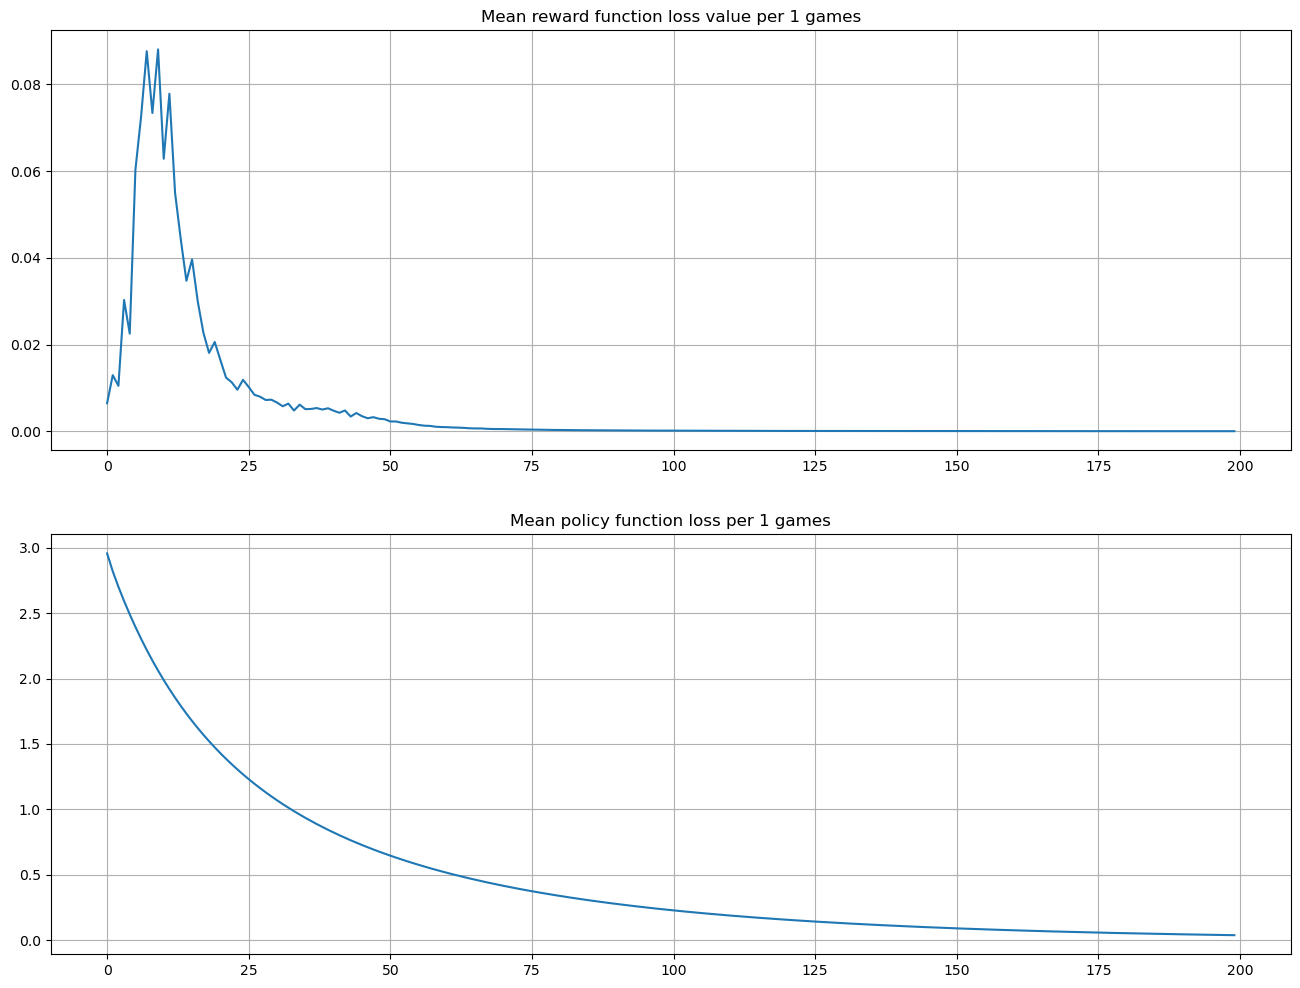

In [38]:
print(f"mean reward loss:{np.mean(mean_loss_rf)} loss: {loss_IOC.item()}")
print(f"mean policy loss:{np.mean(mean_loss_pg)} loss: {loss_bc_traj.item()}")

plt.figure(figsize=[16, 12])
plt.subplot(2, 1, 1)
plt.title(f"Mean reward function loss value per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_rf)
plt.grid()

plt.subplot(2, 1, 2)
plt.title(f"Mean policy function loss per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_pg)
plt.grid()

plt.show()

# Evalutions

In [39]:
for param in updater_obj.policy_network.parameters():
    param.requires_grad = False
updater_obj.policy_network = updater_obj.policy_network.eval()

In [40]:
test_trajectories = []

# loop through each separate trajectory inside the testing dataset
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=True,
                                        is_inference_policy=True)
    
    # store outputs in the dataframe of trajectory information
    traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
    traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
    traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
    test_trajectories.append(traj_df)
    
    del traj_df

In [41]:
test_trajectories[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3,action_pred_avg_logprob,reward_demo_traj,reward_robot_traj
0,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,-0.282575041056,-0.349728494883,-0.452845662832,-0.565150022507,-0.699456930161,0.547154307365,3.498866081238,3.500215530396,3.502852439880,-0.297295480967,-0.325030177832,-0.409291028976,0.012060679495,0.012044415809,0.012012697756,-0.594590902328,-0.650060415268,0.590708971024,42,0,0.036633890122,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,0.239574017927,0.549095345797,0.238551435788,0.718722053781,1.647286037391,0.715654307365,0.226517527240,0.542422829754,0.253069657008,0.679552581719,1.627268489263,0.759208971024,3.500644683838,0.000000000033,0.000000000033
1,0.239574044943,0.549095392227,0.238551437855,0.718722134829,1.647286176682,0.715654313564,-0.301822423935,-0.337225168943,-0.460428625345,-0.603644847870,-0.674450397491,0.539571404457,3.498866081238,3.500215530396,3.502852439880,-0.291256070137,-0.302454471588,-0.376306086779,0.012060679495,0.012044415809,0.012012697756,-0.582512140274,-0.604908943176,0.623693943024,42,1,0.038466785103,0.226517528296,0.542422831059,0.253069669008,0.679552584887,1.627268493176,0.759209007025,0.234890694936,0.542337008440,0.236023801486,0.704672084809,1.627011025321,0.708071404457,0.211891680025,0.534109591122,0.264064647675,0.635675040076,1.602328773367,0.792193943024,3.500644683838,0.000000000033,0.000000000035
2,0.234890684485,0.542337000370,0.236023798585,0.704672053456,1.627011001110,0.708071395755,-0.332956850529,-0.306287735701,-0.449364006519,-0.665913701057,-0.612575531006,0.550635993481,3.498866081238,3.500215530396,3.502852439880,-0.285281956196,-0.279591619968,-0.350697100163,0.012060679495,0.012044415809,0.012012697756,-0.570563912392,-0.559183239937,0.649302899837,42,2,0.040430668741,0.211891680956,0.534109592438,0.264064639807,0.635675042868,1.602328777313,0.792193919420,0.222603332843,0.529386948224,0.239711997827,0.667809998530,1.588160844672,0.719135993481,0.197444953441,0.524919764188,0.272600966612,0.592334860323,1.574759292563,0.817802899837,3.500644683838,0.000000000037,0.000000000039
3,0.222603321075,0.529386937618,0.239711999893,0.667809963226,1.588160812855,0.719135999680,-0.362390547991,-0.268660634756,-0.434770703316,-0.724781036377,-0.537321329117,0.565229296684,3.498866081238,3.500215530396,3.502852439880,-0.281669795513,-0.254779696465,-0.331013202667,0.012060679495,0.012044415809,0.012012697756,-0.563339591026,-0.509559392929,0.668986797333,42,3,0.042768627405,0.197444960475,0.524919748306,0.272600978613,0.592334881425,1.574759244919,0.817802935839,0.209317151556,0.514297032946,0.244576432228,0.627951454667,1.542891098839,0.733729296684,0.182437983521,0.514241984221,0.279162265778,0.547313950562,1.542725952663,0.837486797333,3.500644683838,0.000000000044,0.000000000045
4,0.209317147732,0.514297008514,0.244576424360,0.627951443195,1.542891025543,0.733729273081,-0.381538033485,-0.232243731618,-0.422912865877,-0.763076066971,-0.464487433434,0.577087163925,3.4